In [1]:
import os

# Example: List files in UCF101 dataset
dataset_path = '/kaggle/input/ucf101-action-recognition'
print("Files in UCF101 dataset:")
for root, dirs, files in os.walk(dataset_path): 
    for file in files:
        print(os.path.join(root, file))

Files in UCF101 dataset:
/kaggle/input/ucf101-action-recognition/val.csv
/kaggle/input/ucf101-action-recognition/train.csv
/kaggle/input/ucf101-action-recognition/test.csv
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g11_c01.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g19_c03.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g16_c05.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g14_c02.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g23_c03.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g03_c01.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g17_c04.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g20_c05.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g14_c03.avi
/kaggle/input/ucf101-action-recognition/val/HorseRace/v_HorseRace_g19_c01.avi
/kaggle/input/ucf101-action-recognition/val/Hors

In [6]:
# import kagglehub
# ucf101_action_recognition_path = kagglehub.dataset_download('matthewjansen/ucf101-action-recognition')

In [1]:
import os 
import random
# Path to dataset
dataset_path = "/kaggle/input/ucf101-action-recognition/train"
selected_classes = ['ApplyLipstick','Basketball','Punch','SkateBoarding','LongJump']
print(f"Selected Classes: {selected_classes}")


Selected Classes: ['ApplyLipstick', 'Basketball', 'Punch', 'SkateBoarding', 'LongJump']


In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
from tqdm import tqdm

class UCF101VideoDataset(Dataset):
    def __init__(self, dataset_path, selected_classes, seq_len=10, pred_len=5, transform=None):
        self.dataset_path = dataset_path
        self.selected_classes = selected_classes
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.transform = transform
        
        self.video_paths = self._collect_video_paths()
    
    def _collect_video_paths(self):
        video_paths = []
        for cls in self.selected_classes:
            class_path = os.path.join(self.dataset_path, cls)
            for video in os.listdir(class_path):
                video_paths.append(os.path.join(class_path, video))
        return video_paths
    
    def _extract_frames(self, video_path, max_frames=100):
        frames = []
        cap = cv2.VideoCapture(video_path)
        
        while len(frames) < max_frames and cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            
            # Resizing and converting to grayscale
            frame = cv2.resize(frame, (64, 64))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Convert to tensor
            frame = torch.tensor(frame, dtype=torch.float32) / 255.0  # Normalize to [0, 1]
            
            frames.append(frame)
        
        cap.release()
        return frames
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx): 
        video_path = self.video_paths[idx]
        frames = self._extract_frames(video_path)
        
        if len(frames) < self.seq_len + self.pred_len:
            return None  # Skip videos with insufficient frames
        
        # Randomly selecting input and prediction sequences
        start_idx = random.randint(0, len(frames) - (self.seq_len + self.pred_len))
        input_seq = frames[start_idx:start_idx + self.seq_len]
        target_seq = frames[start_idx + self.seq_len:start_idx + self.seq_len + self.pred_len]
        
        # Convert to torch tensors and add channel dimension
        input_seq = torch.stack([frame.clone().detach().unsqueeze(0) for frame in input_seq])
        target_seq = torch.stack([frame.clone().detach().unsqueeze(0) for frame in target_seq])
        
        return input_seq, target_seq


In [3]:
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        padding = kernel_size // 2
        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=kernel_size,
            padding=padding,
            bias=bias,
        )

    def forward(self, x, hidden_state):
        h_prev, c_prev = hidden_state

        combined = torch.cat([x, h_prev], dim=1) 
        conv_output = self.conv(combined)

        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_dim, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers, output_channels=1, bias=True):
        super(ConvLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_channels = output_channels  # Set the output channels to 1 for grayscale images
        
        self.cells = nn.ModuleList([
            ConvLSTMCell(
                input_dim=input_dim if i == 0 else hidden_dim,
                hidden_dim=hidden_dim,
                kernel_size=kernel_size,
                bias=bias,
            )
            for i in range(num_layers)
        ])
        
        # Output layer to match target shape
        self.output_layer = nn.Conv2d(hidden_dim, self.output_channels, kernel_size=1)

    def forward(self, x, hidden_state=None):
        batch_size, seq_len, channels, height, width = x.size()

        if hidden_state is None:
            hidden_state = [
                (
                    torch.zeros(batch_size, self.hidden_dim, height, width, device=x.device),
                    torch.zeros(batch_size, self.hidden_dim, height, width, device=x.device),
                )
                for _ in range(self.num_layers)
            ]

        layer_output_list = []
        last_state_list = []
        cur_layer_input = x

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cells[layer_idx](cur_layer_input[:, t, :, :, :], (h, c))
                output_inner.append(h)
            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output
            layer_output_list.append(layer_output)
            last_state_list.append((h, c))

        # Stack the outputs along the time dimension
        final_output = layer_output_list[-1]  # Shape: (batch_size, seq_len, hidden_dim, height, width)

        # Reshape to 4D tensor: (batch_size * seq_len, hidden_dim, height, width)
        final_output = final_output.view(-1, self.hidden_dim, height, width)

        # Apply the output layer to match the target shape (1 channel)
        final_output = self.output_layer(final_output)  # Shape: (batch_size * seq_len, output_channels, height, width)

        # Reshape back to the 5D shape: (batch_size, seq_len, output_channels, height, width)
        final_output = final_output.view(batch_size, seq_len, self.output_channels, height, width)

        return final_output, last_state_list


In [4]:
# Hyperparameters
input_dim = 1  # Grayscale images
hidden_dim = 64
kernel_size = 3
num_layers = 2
lr = 1e-3
num_epochs = 30
seq_len = 10 #number of frames 
pred_len = 5 #predicted frames
batch_size = 8 #batch is getting number of video sequences 

# Data loader
transform = transforms.Compose([transforms.ToTensor()])
dataset = UCF101VideoDataset(dataset_path, selected_classes, seq_len, pred_len, transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Initialize model, loss, and optimizer
model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers).to(device="cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for input_seq, target_seq in tqdm(data_loader):
        input_seq, target_seq = input_seq.to("cuda"), target_seq.to("cuda")

        optimizer.zero_grad()
        output_seq, _ = model(input_seq)

        loss = criterion(output_seq[:, -pred_len:], target_seq)
        loss.backward()
        optimizer.step #updates model parameters (weight and biases)

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(data_loader):.4f}")


100%|██████████| 73/73 [00:29<00:00,  2.46it/s]


Epoch [1/30], Loss: 0.2537


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]


Epoch [2/30], Loss: 0.2530


100%|██████████| 73/73 [00:24<00:00,  2.97it/s]


Epoch [3/30], Loss: 0.2532


100%|██████████| 73/73 [00:24<00:00,  2.99it/s]


Epoch [4/30], Loss: 0.2533


100%|██████████| 73/73 [00:24<00:00,  2.99it/s]


Epoch [5/30], Loss: 0.2535


100%|██████████| 73/73 [00:24<00:00,  3.01it/s]


Epoch [6/30], Loss: 0.2540


100%|██████████| 73/73 [00:24<00:00,  2.97it/s]


Epoch [7/30], Loss: 0.2520


100%|██████████| 73/73 [00:24<00:00,  2.95it/s]


Epoch [8/30], Loss: 0.2543


100%|██████████| 73/73 [00:24<00:00,  2.97it/s]


Epoch [9/30], Loss: 0.2534


100%|██████████| 73/73 [00:24<00:00,  2.95it/s]


Epoch [10/30], Loss: 0.2532


100%|██████████| 73/73 [00:24<00:00,  2.98it/s]


Epoch [11/30], Loss: 0.2535


100%|██████████| 73/73 [00:24<00:00,  2.97it/s]


Epoch [12/30], Loss: 0.2552


100%|██████████| 73/73 [00:24<00:00,  2.92it/s]


Epoch [13/30], Loss: 0.2542


100%|██████████| 73/73 [00:24<00:00,  2.98it/s]


Epoch [14/30], Loss: 0.2523


100%|██████████| 73/73 [00:24<00:00,  2.98it/s]


Epoch [15/30], Loss: 0.2533


100%|██████████| 73/73 [00:24<00:00,  2.95it/s]


Epoch [16/30], Loss: 0.2515


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]


Epoch [17/30], Loss: 0.2525


100%|██████████| 73/73 [00:24<00:00,  2.95it/s]


Epoch [18/30], Loss: 0.2533


100%|██████████| 73/73 [00:24<00:00,  2.97it/s]


Epoch [19/30], Loss: 0.2520


100%|██████████| 73/73 [00:24<00:00,  2.98it/s]


Epoch [20/30], Loss: 0.2530


100%|██████████| 73/73 [00:24<00:00,  2.97it/s]


Epoch [21/30], Loss: 0.2510


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]


Epoch [22/30], Loss: 0.2517


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]


Epoch [23/30], Loss: 0.2519


100%|██████████| 73/73 [00:24<00:00,  2.98it/s]


Epoch [24/30], Loss: 0.2529


100%|██████████| 73/73 [00:24<00:00,  2.95it/s]


Epoch [25/30], Loss: 0.2526


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]


Epoch [26/30], Loss: 0.2543


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]


Epoch [27/30], Loss: 0.2532


100%|██████████| 73/73 [00:24<00:00,  2.98it/s]


Epoch [28/30], Loss: 0.2499


100%|██████████| 73/73 [00:24<00:00,  2.94it/s]


Epoch [29/30], Loss: 0.2530


100%|██████████| 73/73 [00:24<00:00,  2.96it/s]

Epoch [30/30], Loss: 0.2536


In [5]:
save_path = f"convlstm_model.pth"
torch.save(model.state_dict(), save_path)

/tmp/ipykernel_23/3374549932.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
Testing:   0%|          | 0/12 [00:00<?, ?it/

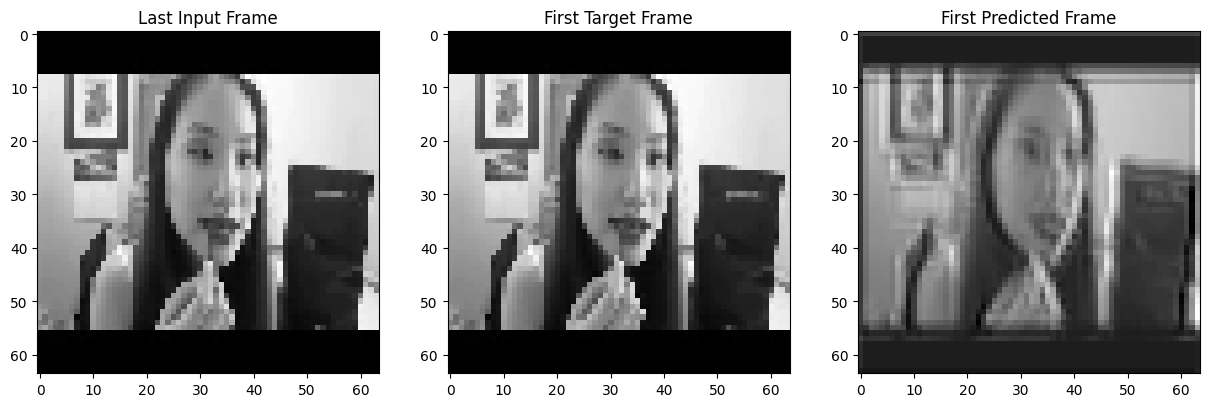

Testing:   8%|▊         | 1/12 [00:00<00:09,  1.15it/s]

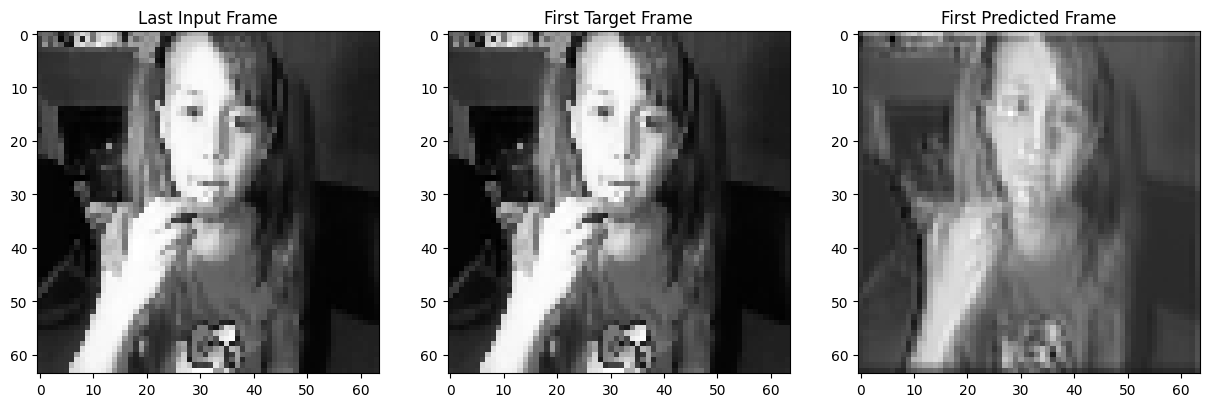

Testing:  17%|█▋        | 2/12 [00:01<00:08,  1.11it/s]

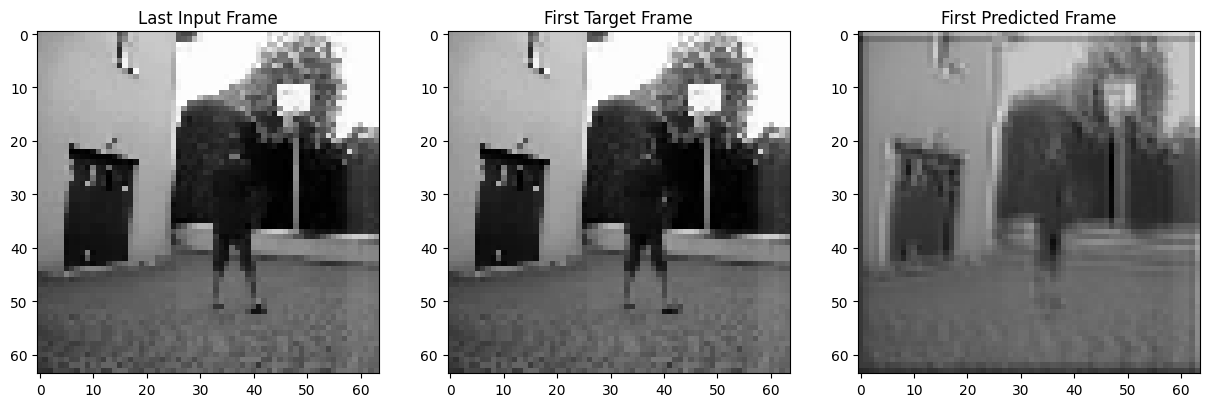

Testing:  25%|██▌       | 3/12 [00:02<00:07,  1.17it/s]

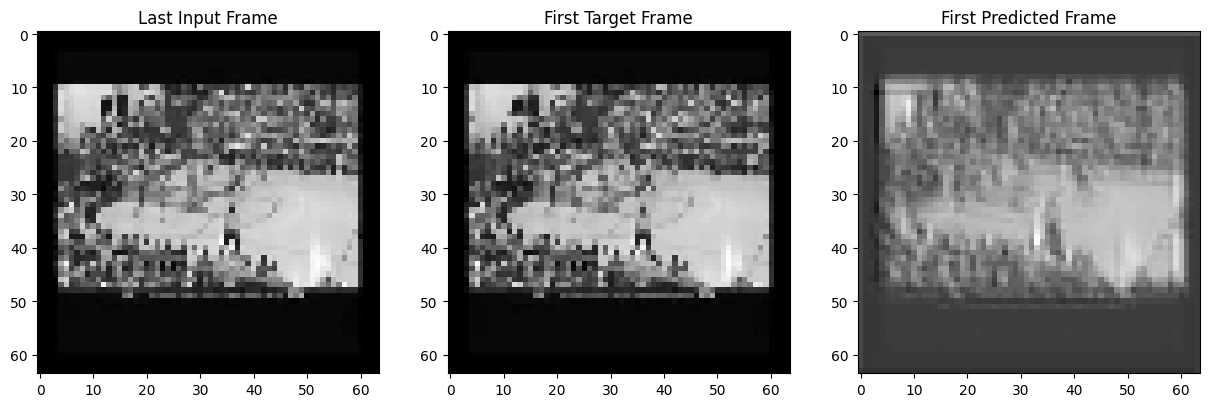

Testing:  33%|███▎      | 4/12 [00:03<00:06,  1.22it/s]

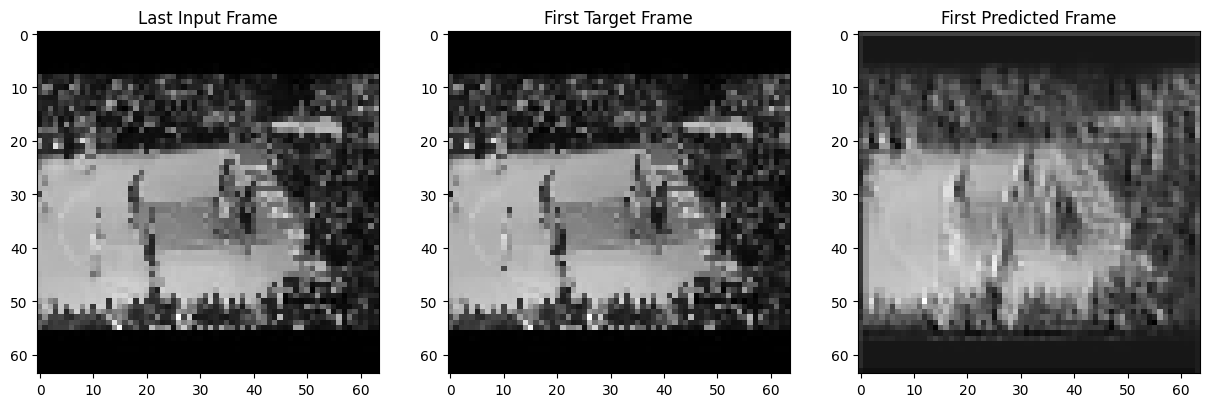

Testing:  42%|████▏     | 5/12 [00:04<00:05,  1.22it/s]

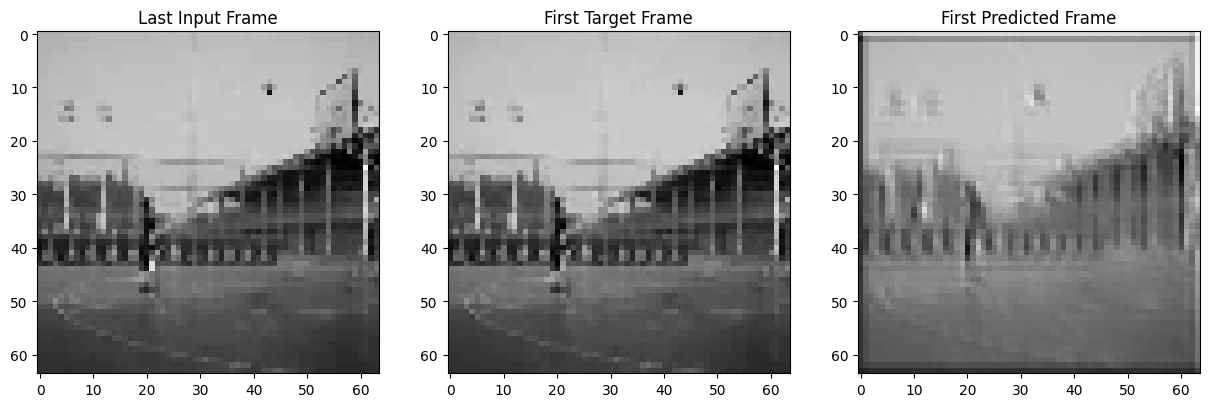

Testing:  50%|█████     | 6/12 [00:04<00:04,  1.22it/s]

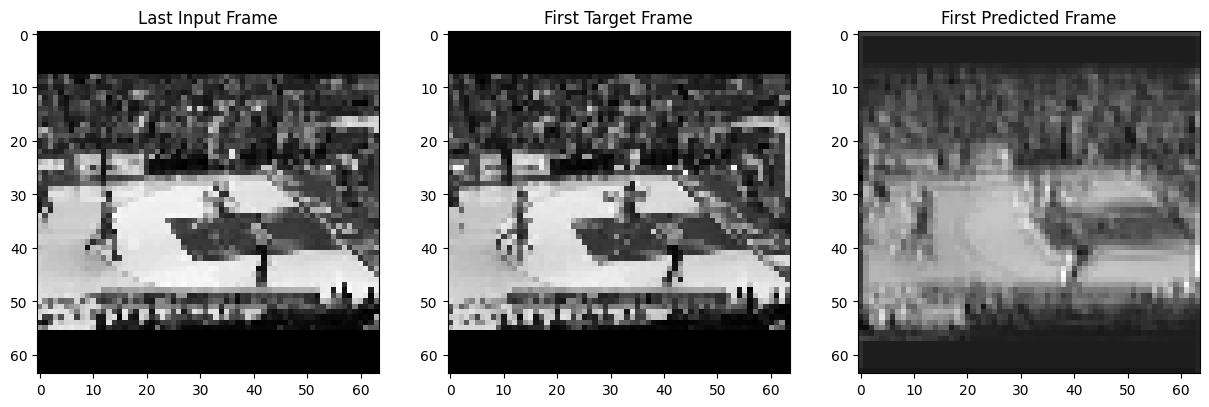

Testing:  58%|█████▊    | 7/12 [00:05<00:04,  1.23it/s]

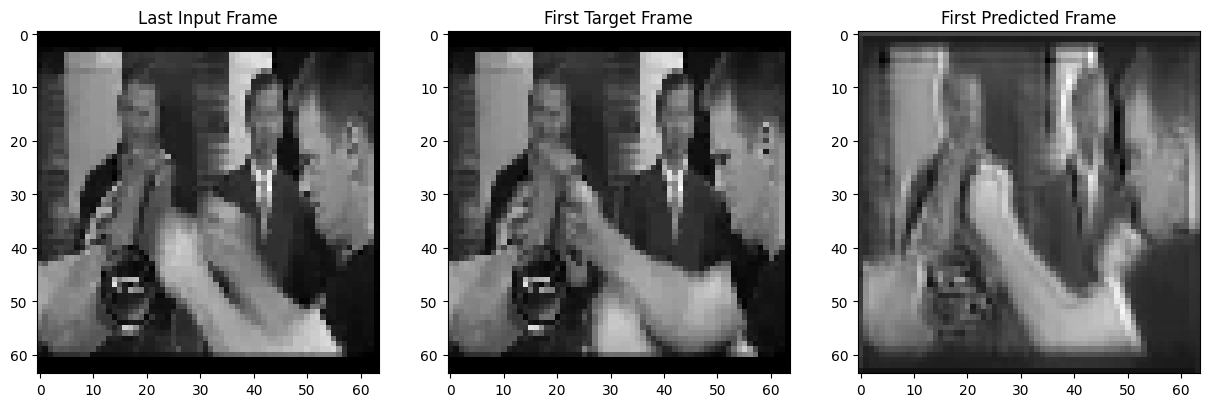

Testing:  67%|██████▋   | 8/12 [00:06<00:03,  1.23it/s]

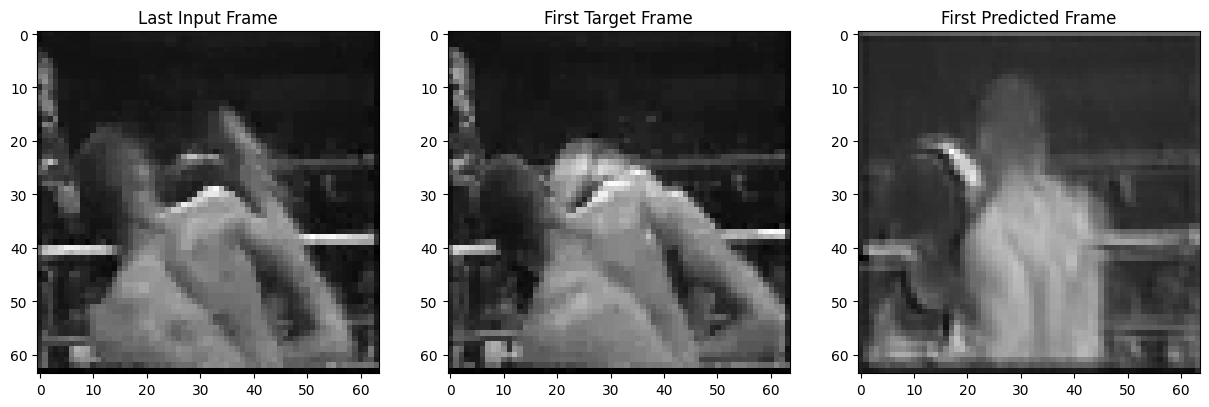

Testing:  75%|███████▌  | 9/12 [00:07<00:02,  1.23it/s]

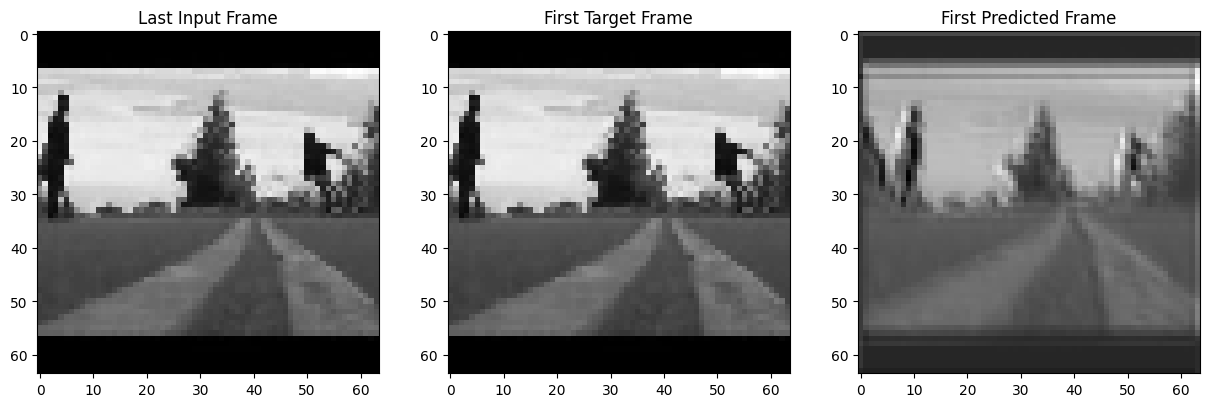

Testing:  83%|████████▎ | 10/12 [00:08<00:01,  1.17it/s]

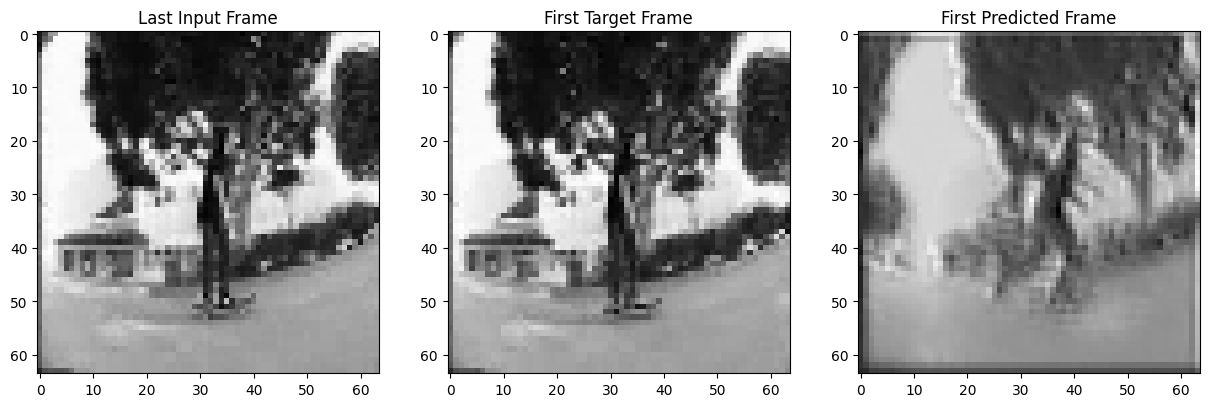

Testing:  92%|█████████▏| 11/12 [00:09<00:00,  1.18it/s]

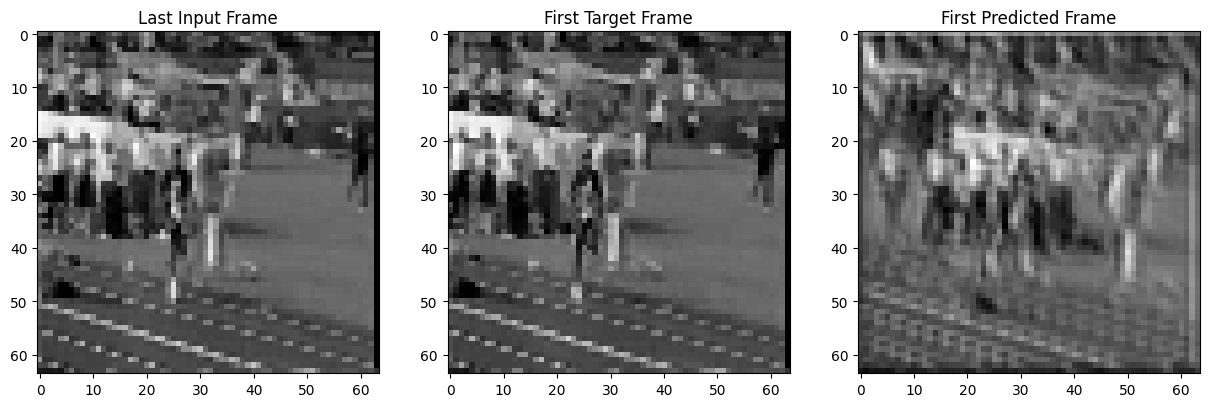

Testing: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

Average Test Loss: 0.2464


In [6]:
import torch
import numpy as np
import cv2
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


# Path to dataset and model
dataset_path = '/kaggle/input/ucf101-action-recognition/test'  # Path to the test set
model_path = "/kaggle/working/convlstm_model.pth"  # Path to the trained model
selected_classes = ['ApplyLipstick', 'Basketball', 'Punch', 'SkateBoarding', 'LongJump']
seq_len = 10  # Length of the input sequence
pred_len = 5  # Length of the predicted sequence
batch_size = 8  # Batch size for testing

# Data loader for the test set
test_dataset = UCF101VideoDataset(dataset_path, selected_classes, seq_len, pred_len, transform=None)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Initialize model
input_dim = 1  # Grayscale images
hidden_dim = 64
kernel_size = 3
num_layers = 2
model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_layers).to(device="cuda")

# Load trained model weights
model.load_state_dict(torch.load(model_path))

# Set model to evaluation mode
model.eval()

# Testing loop
def test_model():
    total_loss = 0
    criterion = torch.nn.MSELoss()
    
    # Iterate over test data
    for input_seq, target_seq in tqdm(test_data_loader, desc="Testing"):
        if input_seq is None:
            continue  # Skip if the video has insufficient frames
        
        input_seq, target_seq = input_seq.to("cuda"), target_seq.to("cuda")
        
        # Predict future frames
        with torch.no_grad():
            predicted_seq, _ = model(input_seq)
        
        # Calculate loss between predicted frames and actual target frames
        loss = criterion(predicted_seq[:, -pred_len:], target_seq)  # Only compare the predicted frames
        total_loss += loss.item()
        
        # Visualize some predictions for debugging (optional)
        visualize_predictions(input_seq, target_seq, predicted_seq)
    
    avg_loss = total_loss / len(test_data_loader)
    print(f"Average Test Loss: {avg_loss:.4f}")

# Visualize a few frames of the input sequence, target sequence, and predictions
def visualize_predictions(input_seq, target_seq, predicted_seq):
    batch_size, seq_len, channels, height, width = input_seq.size()
    
    # Get the first video from the batch (for simplicity, visualizing just the first video)
    input_frames = input_seq[0].cpu().numpy()  # Shape: (seq_len, channels, height, width)
    target_frames = target_seq[0].cpu().numpy()
    predicted_frames = predicted_seq[0].cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_frames[-1, 0], cmap='gray')
    axes[0].set_title('Last Input Frame')
    
    axes[1].imshow(target_frames[0, 0], cmap='gray')
    axes[1].set_title('First Target Frame')
    
    axes[2].imshow(predicted_frames[0, 0], cmap='gray')
    axes[2].set_title('First Predicted Frame')
    
    plt.show()

# Run the testing function
test_model()


Testing with video: /kaggle/input/ucf101-action-recognition/test/ApplyLipstick/v_ApplyLipstick_g06_c05.avi
Total frames in video: 100


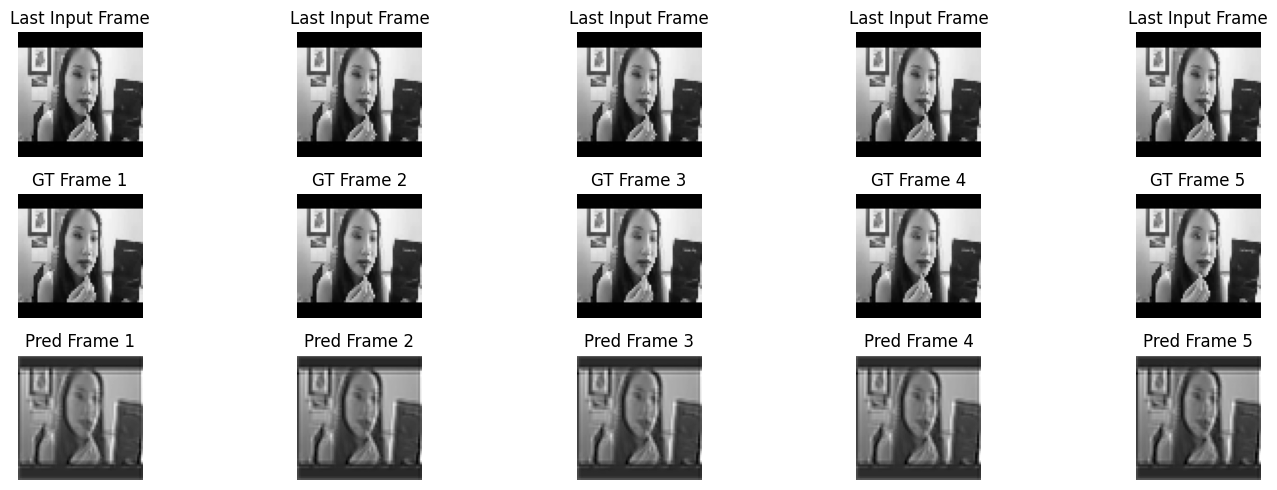

In [7]:
import torch
import cv2
import matplotlib.pyplot as plt

# Function to extract frames from a video
def extract_frames(video_path, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened() and len(frames) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize and convert to grayscale
        frame = cv2.resize(frame, (64, 64))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(torch.tensor(frame, dtype=torch.float32).unsqueeze(0) / 255.0)  # Normalize to [0, 1]
    cap.release()
    return torch.stack(frames)

# Pick a video from the test dataset
test_video_path = os.path.join(dataset_path, selected_classes[0], os.listdir(os.path.join(dataset_path, selected_classes[0]))[0])
print(f"Testing with video: {test_video_path}")

# Extract frames from the selected video
video_frames = extract_frames(test_video_path)
print(f"Total frames in video: {video_frames.size(0)}")

# Ensure there are enough frames for input and prediction
if video_frames.size(0) < seq_len + pred_len:
    print("Not enough frames in the selected video for testing.")
else:
    # Prepare input and ground truth frames
    input_seq = video_frames[:seq_len].unsqueeze(0).to("cuda")  # Shape: (1, seq_len, 1, 64, 64)
    target_seq = video_frames[seq_len:seq_len + pred_len].unsqueeze(0).to("cuda")  # Ground truth
    
    # Predict the next frames
    model.eval()
    with torch.no_grad():
        predicted_seq, _ = model(input_seq)
        predicted_seq = predicted_seq[:, -pred_len:]  # Shape: (1, pred_len, 1, 64, 64)

    # Visualize input, ground truth, and predicted frames
    def visualize_results(input_seq, target_seq, predicted_seq):
        fig, axes = plt.subplots(3, pred_len, figsize=(15, 5))
        
        # Input sequence (last frame of the input)
        for i in range(pred_len):
            axes[0, i].imshow(input_seq[0, seq_len-1, 0].cpu().numpy(), cmap='gray')
            axes[0, i].set_title("Last Input Frame")
            axes[0, i].axis('off')
        
        # Ground truth frames
        for i in range(pred_len):
            axes[1, i].imshow(target_seq[0, i, 0].cpu().numpy(), cmap='gray')
            axes[1, i].set_title(f"GT Frame {i+1}")
            axes[1, i].axis('off')
        
        # Predicted frames
        for i in range(pred_len):
            axes[2, i].imshow(predicted_seq[0, i, 0].cpu().numpy(), cmap='gray')
            axes[2, i].set_title(f"Pred Frame {i+1}")
            axes[2, i].axis('off')
        
        plt.tight_layout()
        plt.show()

    visualize_results(input_seq, target_seq, predicted_seq)


In [8]:
import torch
import cv2
import numpy as np
import os

def frames_to_video(input_seq, target_seq, predicted_seq, output_filename='/kaggle/working/combined_prediction.mp4'):
    """
    Convert input, ground truth, and predicted frames into a single video
    
    Args:
    - input_seq: Input sequence of frames (torch tensor)
    - target_seq: Ground truth target frames (torch tensor)
    - predicted_seq: Predicted frames (torch tensor)
    - output_filename: Path to save the output video
    """
    # Convert tensors to numpy and ensure correct format
    input_frames = input_seq[0].cpu().numpy()
    target_frames = target_seq[0].cpu().numpy()
    predicted_frames = predicted_seq[0].cpu().numpy()

    # Combine input, target, and predicted frames
    # Assuming frames are in (seq_len, channels, height, width) format
    # Squeeze channel dimension and convert to uint8
    input_frames = (input_frames * 255).astype(np.uint8).squeeze()
    target_frames = (target_frames * 255).astype(np.uint8).squeeze()
    predicted_frames = (predicted_frames * 255).astype(np.uint8).squeeze()

    # Determine video parameters
    height, width = input_frames[0].shape
    
    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_filename, fourcc, 10.0, (width, height), isColor=False)

    # Write frames to video
    # First, write input frames
    for frame in input_frames:
        out.write(frame)
    
    # Then, write ground truth frames
    for frame in target_frames:
        out.write(frame)
    
    # Finally, write predicted frames
    for frame in predicted_frames:
        out.write(frame)

    # Release the video writer
    out.release()

    print(f"Video saved to {output_filename}")

# You can call this function in your existing prediction script
# after generating input_seq, target_seq, and predicted_seq
frames_to_video(input_seq, target_seq, predicted_seq)

Video saved to /kaggle/working/combined_prediction.mp4


In [9]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 33.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.2/320.2 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 106.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.111.0
    Uninstalling fastapi-0.111.0:
      Successfully uninstalled fastapi-0.111.0


In [ ]:
import gradio as gr
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import os

def predict_video(video):
    # Model path
    MODEL_PATH = '/kaggle/working/convlstm_model.pth'
    
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = ConvLSTM(
        input_dim=1, 
        hidden_dim=64, 
        kernel_size=3, 
        num_layers=2
    )
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
    model.to(device)
    
    # Extract frames
    cap = cv2.VideoCapture(video)
    frames = []
    
    while cap.isOpened() and len(frames) < 100:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.resize(frame, (64, 64))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(torch.tensor(frame, dtype=torch.float32).unsqueeze(0) / 255.0)
    
    cap.release()
    
    if len(frames) < 15:
        return None, "Not enough frames in the video"
    
    video_frames = torch.stack(frames)
    
    # Prepare sequences
    input_seq = video_frames[:10].unsqueeze(0).to(device)
    target_seq = video_frames[10:15].unsqueeze(0).to(device)
    
    # Predict frames
    with torch.no_grad():
        predicted_seq, *_ = model(input_seq)
        predicted_seq = predicted_seq[:, -5:]
    
    # Combine and save video
    combined_frames = torch.cat([input_seq[0, -5:], target_seq[0], predicted_seq[0]], dim=0)
    combined_frames = (combined_frames.cpu().numpy() * 255).astype(np.uint8).squeeze()
    
    output_video_path = 'combined_frames.avi'
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, 10.0, (64, 64), isColor=False)
    
    for frame in combined_frames:
        out.write(frame)
    out.release()
    
    # Visualization
    fig, axes = plt.subplots(3, 5, figsize=(15, 5))
    
    for i in range(5):
        axes[0, i].imshow(input_seq[0, -5+i, 0].cpu().numpy(), cmap='gray')
        axes[0, i].set_title(f"Last Input Frame {i+1}")
        axes[0, i].axis('off')
        
        axes[1, i].imshow(target_seq[0, i, 0].cpu().numpy(), cmap='gray')
        axes[1, i].set_title(f"GT Frame {i+1}")
        axes[1, i].axis('off')
        
        axes[2, i].imshow(predicted_seq[0, i, 0].cpu().numpy(), cmap='gray')
        axes[2, i].set_title(f"Pred Frame {i+1}")
        axes[2, i].axis('off')
    
    plt.tight_layout()
    
    # Save visualization
    fig_path = 'prediction_visualization.png'
    plt.savefig(fig_path)
    plt.close()
    
    return output_video_path, fig_path

# Create Gradio interface
iface = gr.Interface(
    fn=predict_video,
    inputs=gr.Video(),
    outputs=[
        gr.Video(label="Combined Frames Video"),
        gr.Image(label="Prediction Visualization")
    ],
    title="Video Frame Prediction",
    description="Upload a video to predict future frames"
)

# Launch the app
iface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://12e95be580d2951c8c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipykernel_23/4173253653.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
/opt/conda/lib/python3.1